In [1]:
#pip install num2words
pip install unidecode

In [48]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from string import punctuation
from lxml import etree
from collections import defaultdict, Counter
#from num2words import num2words
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
from unidecode import unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Mounted at /content/drive


In [4]:
def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    return ' '.join([stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                     for w in tknzr.tokenize(col) \
                     if w not in list(sw) and w.isalpha()])

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Chargement

In [51]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding='utf-8', \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())
cols = train.columns

print(train.info())

print('='*30)
for col in cols:
    freq[col] = Counter(' '.join(train[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
          format(sum(dict(freq[col]).values()), col, len(freq[col])))

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 169828 to 1669645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
428719 mots dans "Title" dont 37241 distincts
6055132 mots dans "Body" dont 561841 distincts
50000 mots dans "Tags" dont 37101 distincts


,Title,Body,Tags
169828,what are the real benefits of visual studio te...,<p>interested if anyone has used vsts database...,<sql-server><database-tools>
431644,how can i hook into the current formsauthentic...,<p>i've got an httpmodule in my application th...,<asp.net><events><forms-authentication><httpmo...
1450121,is there any sync algorithm/reference availabl...,<p>i'm planning to write a program to sync a f...,<algorithm><synchronization>
426609,how to assign profile values?,"<p>i don't know what i am missing, but i added...",<asp.net><asp.net-mvc><asp.net-membership><pro...
14646,"how to add ""project description"" in fogbugz?",<p>when i create a new project (or even when i...,<fogbugz>


In [54]:
'ß'.decode()

AttributeError: ignored

# Nettoyage du dataframe

In [6]:
# Stopwords nltk 
sw_std = set(nltk.corpus.stopwords.words('english')) 

tokenizer = nltk.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*30)
for col in ['Title', 'Body']:
    if col == 'Body':
        # Convertion du html en chaine standard 
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()
        train[col] = train[col].apply(conv_html)
        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    # Tokenisation et suppression des stopwords
    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=sw_std, lmtzr=lemmatizer, stmr=stemmer)
    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

# Reformatage des tags
print('Traitement des tags ', end='')
start_time = timeit.default_timer()
# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split('><')))
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(x[1:-1].split('><')))
elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

print('='*30)
for col in cols:
    freq[col] = Counter(' '.join(train[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
            format(sum(dict(freq[col]).values()), col, len(freq[col])))

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 54.3 sec
Conversion html de "Body" -> OK en 20.4 sec
Nettoyage/lemmatisation de "Body" -> OK en 4.28e+02 sec
Traitement des tags -> OK en 0.0803 sec
274364 mots dans "Title" dont 12604 distincts
2311819 mots dans "Body" dont 42566 distincts
145824 mots dans "Tags" dont 10494 distincts


,Title,Body,Tags,nTags
169828,real benefit visual studio team system databas...,interest anyon use vst databas edit extens fea...,sql-server database-tools,2
431644,hook current formsauthenticationmodul medium t...,get httpmodul applic hook formsauthenticationm...,asp.net events forms-authentication httpmodule...,5
1450121,sync algorithm refer avail sync directori,plan write program sync folder real time acros...,algorithm synchronization,2
426609,assign profil valu,know miss add profil properti web config file ...,asp.net asp.net-mvc asp.net-membership profile,4
14646,add project descript fogbugz,creat new project even edit sampl project way ...,fogbugz,1


## Explorations des tags

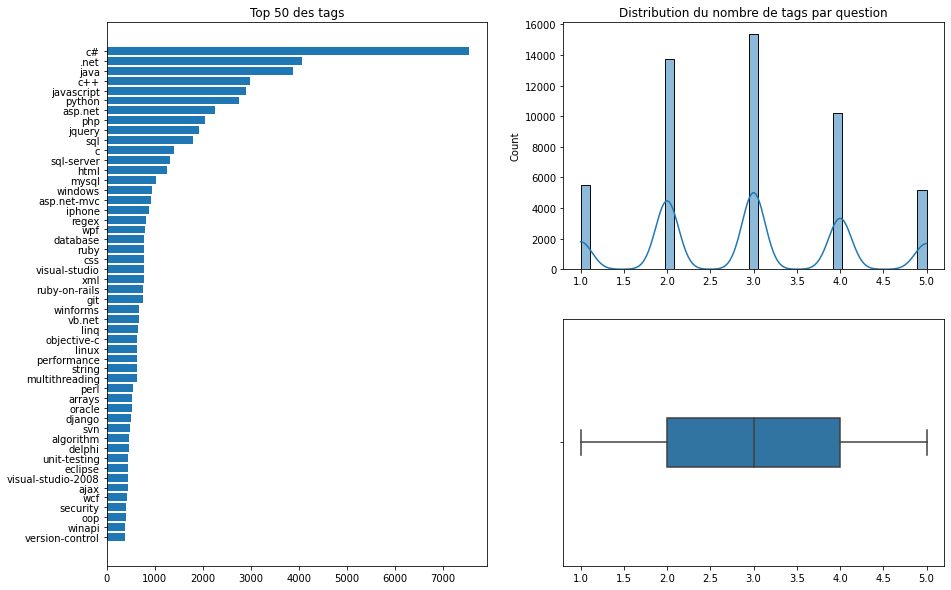

In [7]:
top = 50

fig = plt.figure(1, figsize=(15, 10))
plt.subplot(121)
plt.barh([k for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])])
plt.title('Top {} des tags'.format(top))
plt.subplot(222)
plt.title('Distribution du nombre de tags par question')
sns.histplot(train['Tags'].apply(lambda x: len(x.split())).values, kde=True)
plt.subplot(224)
sns.boxplot(x=train['Tags'].apply(lambda x: len(x.split())).values, width=0.2)

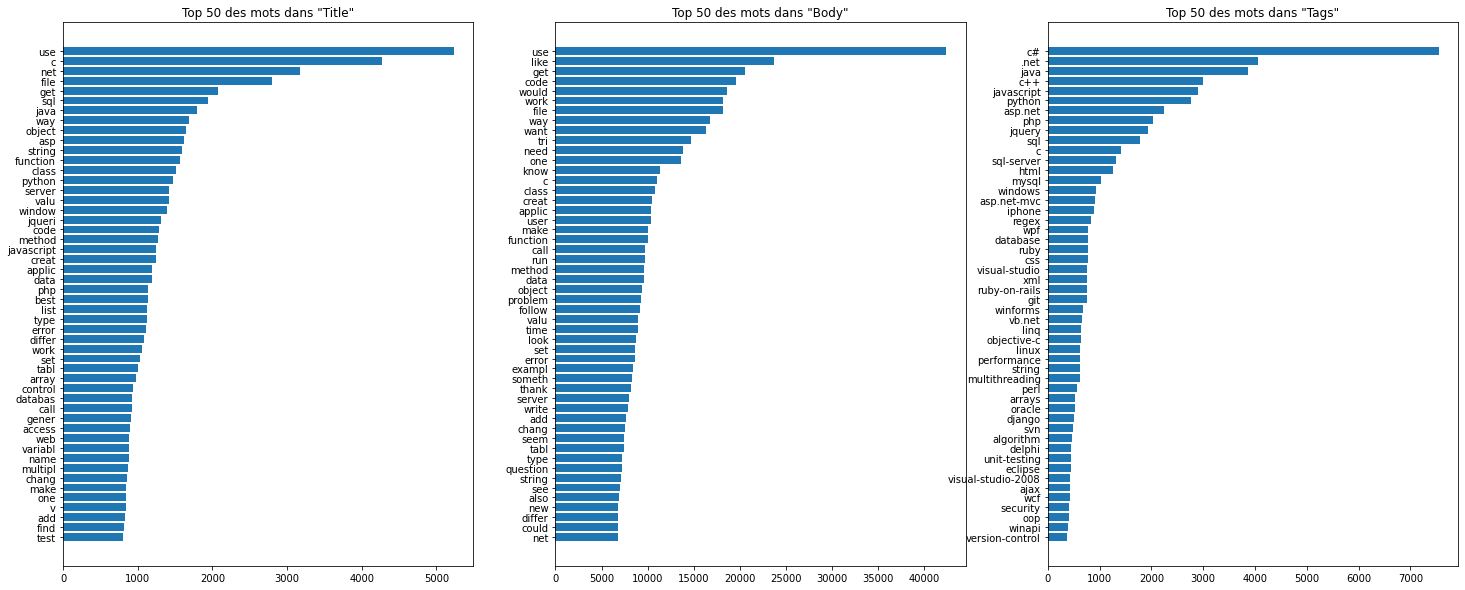

In [8]:
cpt = 1
fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 
plt.show() 

## Extra stopwords
J'enlève les radicaux qui ne me semblent pas discriminants (ex. use, ...)

262222 mots dans "Title" dont 12586 distincts
2127882 mots dans "Body" dont 42548 distincts


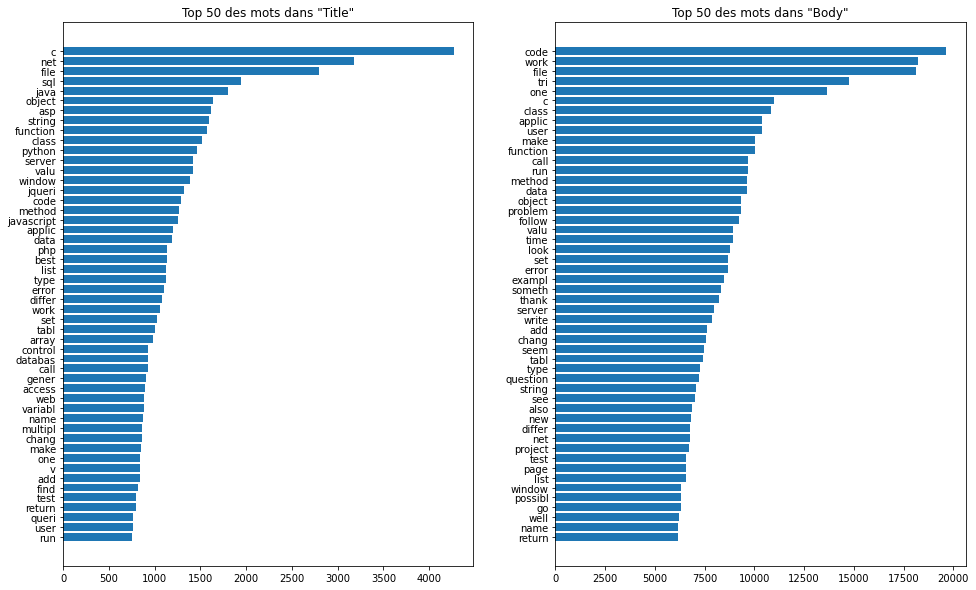

In [9]:
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb'') 
cpt = 1

fig = plt.figure(1, figsize=(25, 10))

for col in  ['Title', 'Body']:
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in extra_sw]))
    freq[col] = Counter(' '.join(train[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
        format(sum(dict(freq[col]).values()), col, len(freq[col])))

    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 
    
print('='*30)

# Réduction du scope
Pour commencer, je considère les questions avec 1 seul tag 

In [10]:
train_1T = train[train.nTags == 1]

for col in cols:
    freq[col] = Counter(' '.join(train_1T[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
            format(sum(dict(freq[col]).values()), col, len(freq[col])))

train_1T.head()

27662 mots dans "Title" dont 3747 distincts
190728 mots dans "Body" dont 9813 distincts
5512 mots dans "Tags" dont 867 distincts


,Title,Body,Tags,nTags
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1
34017938,decrement valu scheme,procedur find n small prime larg add paramet n...,scheme,1
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1


Réduction aux 50 top tags

17572 mots dans "Title" dont 2539 distincts
114765 mots dans "Body" dont 7057 distincts
3481 mots dans "Tags" dont 50 distincts


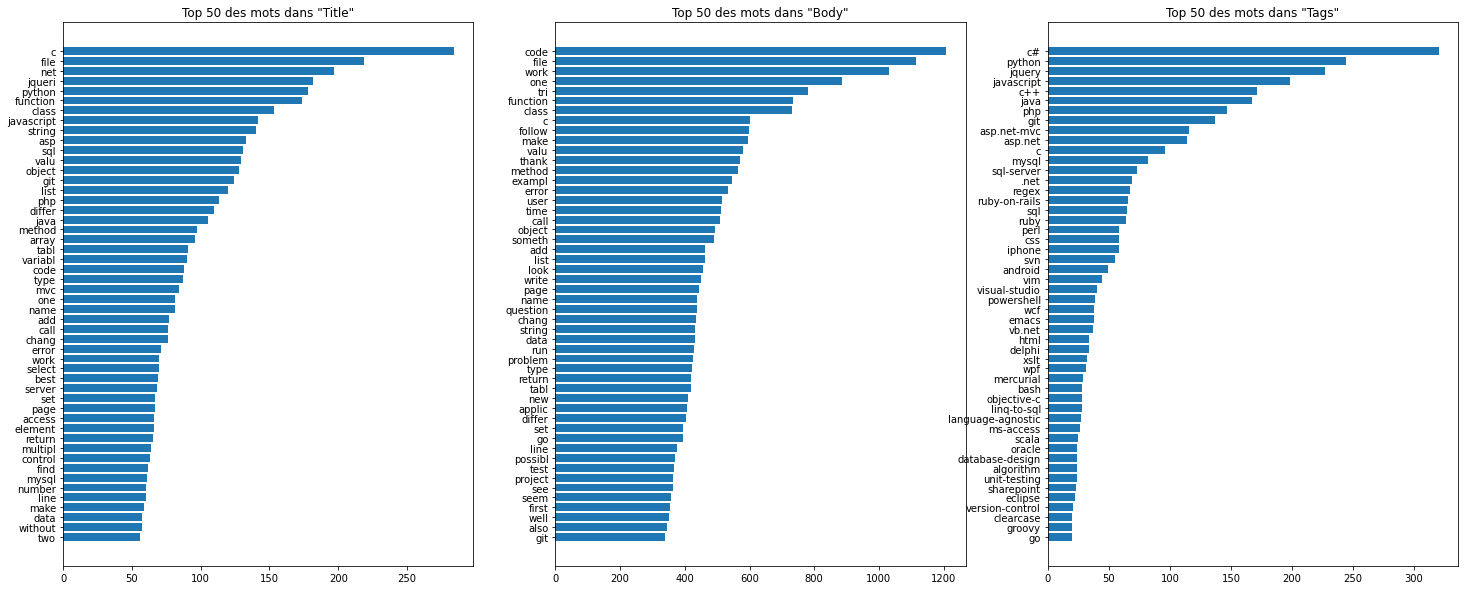

In [11]:
cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:top]).keys())]

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    freq[col] = Counter(' '.join(train_1T[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
            format(sum(dict(freq[col]).values()), col, len(freq[col])))
    
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 

print('='*30)

# TF-IDF

In [12]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\w{1,}')

## Focus Title

In [13]:
tfidf_Title_v = tfidf_vectorizer.fit_transform(train_1T['Title'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Title = pd.DataFrame(tfidf_Title_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Title.head()

,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,advantag,...,within,without,withouth,wizard,woe,word,work,workaround,workbook,worker,world,worri,worth,wpf,wrap,writabl,write,writeabl,writefil,writeln,wrong,wysiwyg,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,ye,year,yet,yield,zcat,zehut,zero,zip,ziparch,zoom,ß
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.343232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1312,mean,0.750079
1905,rubi,0.661349
1696,pro,0.000000
1689,primit,0.000000
1690,princip,0.000000
...,...,...
847,forget,0.000000
848,fork,0.000000
849,forloop,0.000000
850,form,0.000000


In [15]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


### PCA

In [16]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Title.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.0018182  0.00181221] 0.003630412152806544


### Clustering

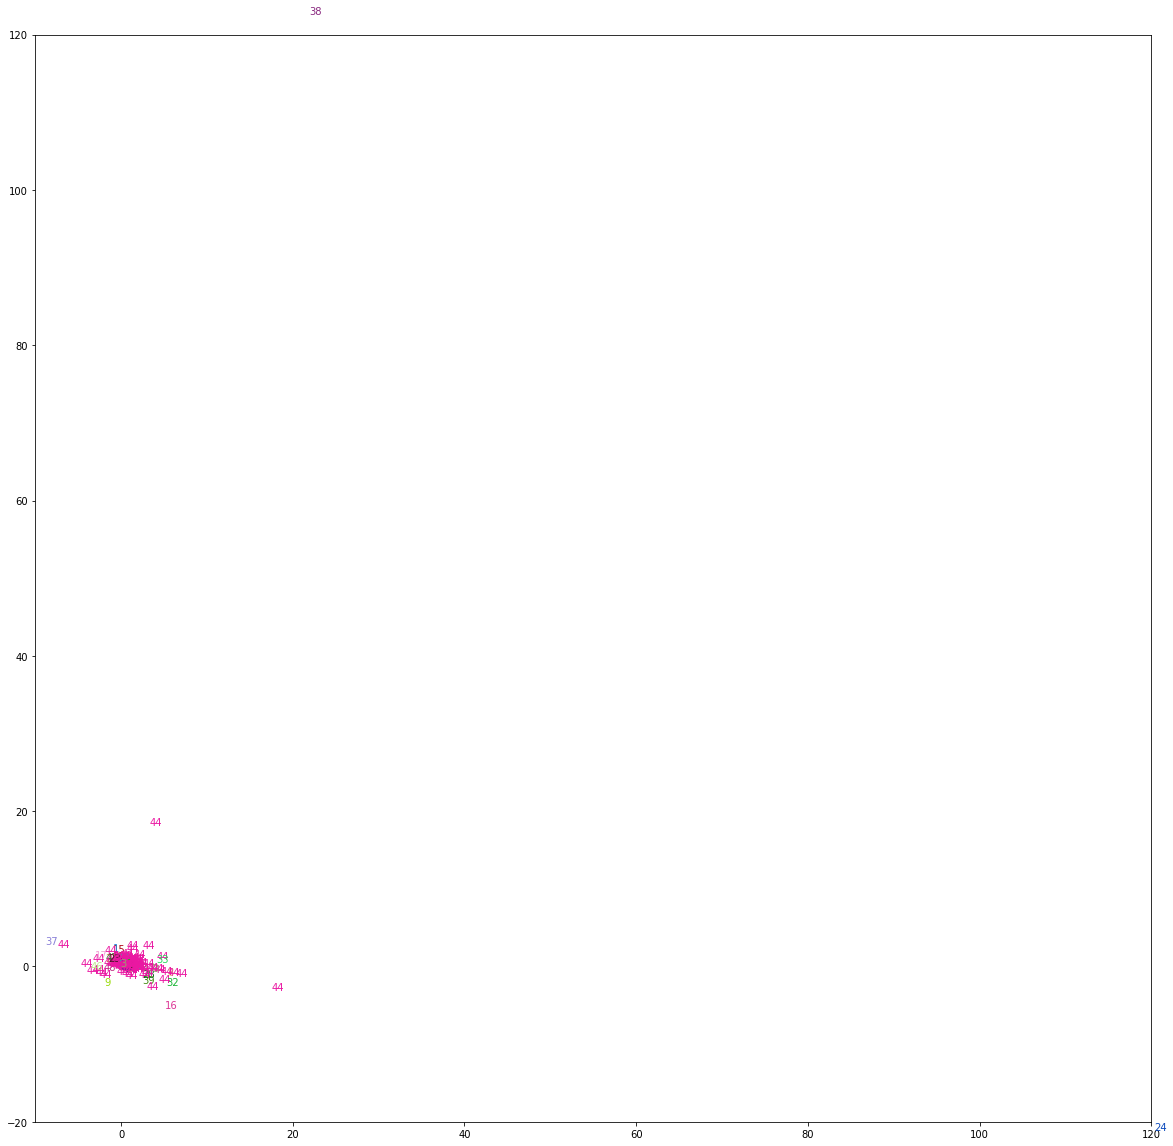

Silhouette Coefficient: -0.044


In [17]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [18]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,14,1,1,48,1,1,1,1,43,1,1,1,1,1,1,1,1,1,14,33,1,1,1,47,1,1,1,94,1,27,1,1,1,1,14,1,1,1,1,1,1,4,1,1,3104,1,1,1,1,1


### Classification supervisée

In [19]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Title, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 2539), (1045, 2539))

accuracy 65.00% time 5.05s

Confusion matrix, without normalization


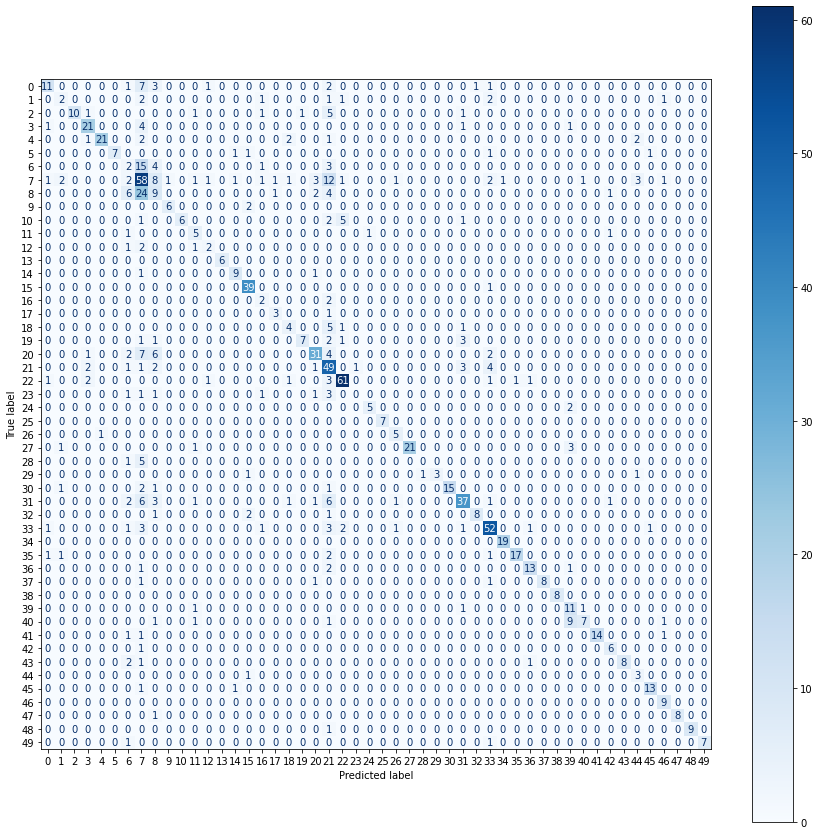

Normalized confusion matrix


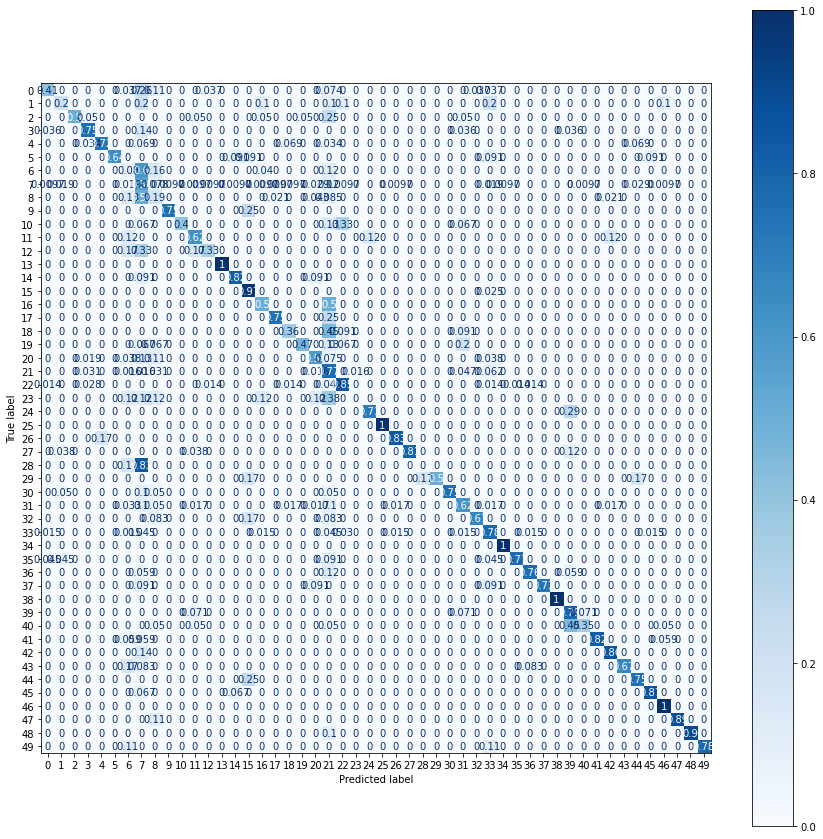

In [20]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

## Focus Body

In [21]:
tfidf_Body_v = tfidf_vectorizer.fit_transform(train_1T['Body'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Body = pd.DataFrame(tfidf_Body_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Body.head()

,aaa,aaaaaa,aabbc,aandb,aarrggbb,ab,abandon,abbrevi,abbyy,abc,abcd,abcdefghi,abil,abl,abnorm,abort,aboutm,abovement,absenc,absolut,abstract,absurd,abt,abus,ac,academ,academi,acccess,accdb,accent,accept,acces,access,accessor,accid,accident,accommod,accompani,accomplish,accord,...,year,yearli,yellow,yesterday,yet,yield,yike,yolk,york,young,youtub,yu,yy,zc,zed,zehut,zeppelin,zero,zf,zi,zijab,zip,ziparch,zone,zoom,zope,zqw,zsh,zubair,ß,ä,äöæaðøñòòñ,å,æ,ôÿ,ö,û,ü,üö,š
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
'ß'.isalpha()

True

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1312,mean,0.750079
1905,rubi,0.661349
1696,pro,0.000000
1689,primit,0.000000
1690,princip,0.000000
...,...,...
847,forget,0.000000
848,fork,0.000000
849,forloop,0.000000
850,form,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Title.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00180626 0.00179   ] 0.0035962549910363946


Clustering

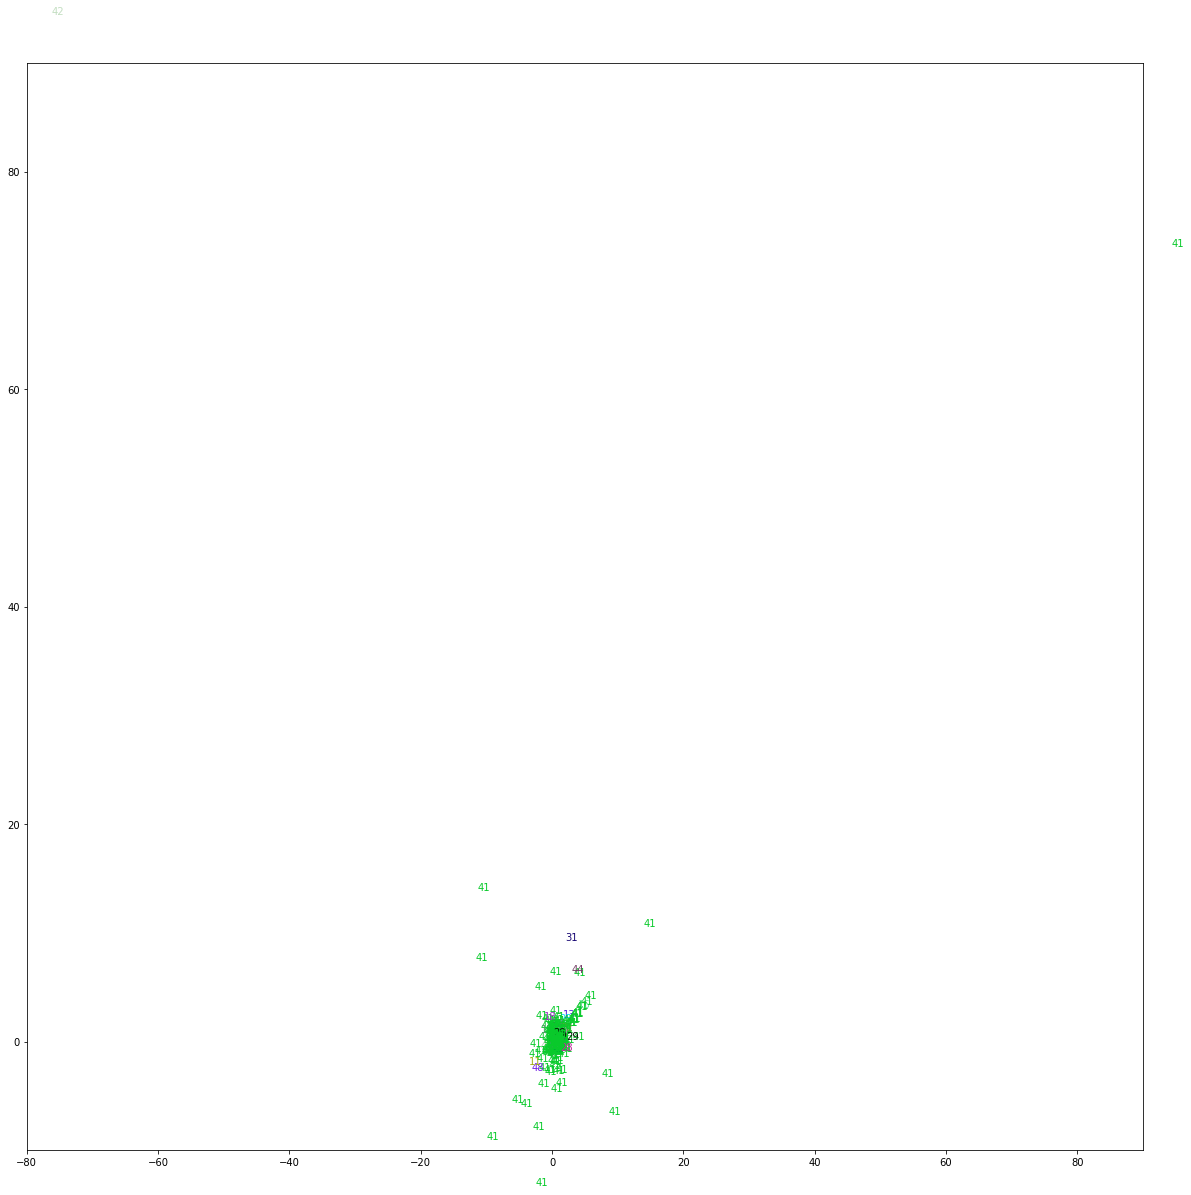

Silhouette Coefficient: -0.044


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,2,7,38,1,1,1,1,1,1,1,9,1,1,1,1,11,1,79,27,1,1,1,1,1,1,1,1,1,1,38,1,1,1,1,2,1,5,1,1,1,1,3223,1,2,1,1,1,1,1,1


Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Title, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 2539), (1045, 2539))

accuracy 65.00% time 3.99s

Confusion matrix, without normalization


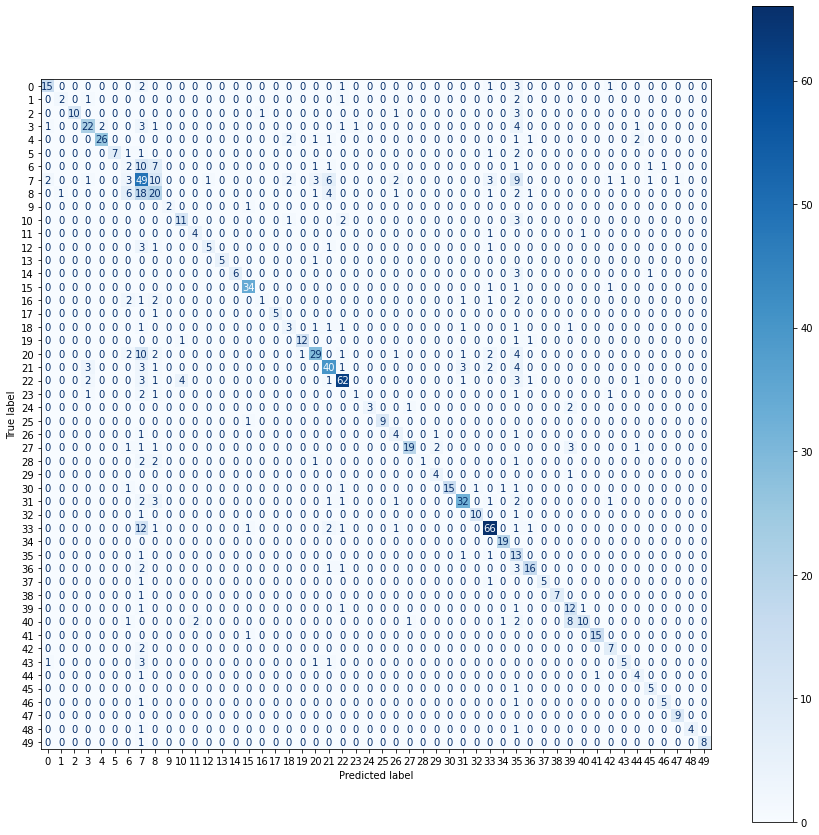

Normalized confusion matrix


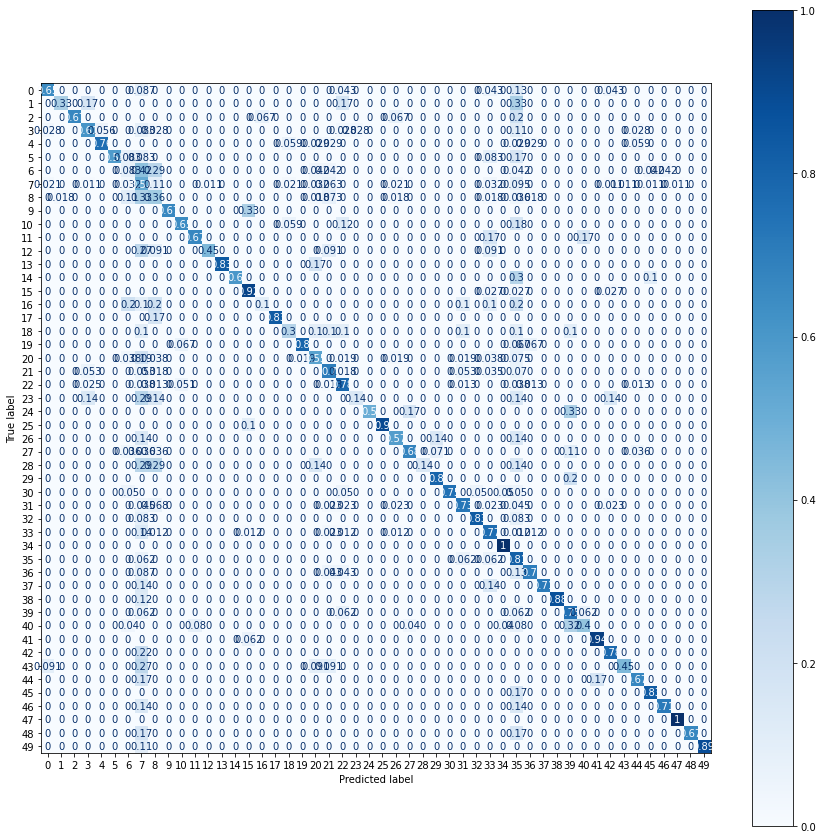

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

# LDA

In [20]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 50

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tfidf_Title_v)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [21]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf.columns[:-1], no_top_words)

Topic 0:
play check sound hasvalu nullab valu comparison digit represent idiomat
Topic 1:
count group div id cs per launch differ minut page
Topic 2:
javascript type multipl practic destructor best differ user mean iter
Topic 3:
escap xslt charact rubi queri mean param room weird cdata
Topic 4:
sql queri mysql string tabl valu result linq row convert
Topic 5:
java unknown friend level protect benefit digit term runtim great
Topic 6:
earlier baselin treat clearcas vertex timespan revert fxcop backtrack protect
Topic 7:
function class c method variabl express call php python string
Topic 8:
regex replac text filter detect window encod enter scroll realli
Topic 9:
align phrase vertic httpcontext obsolet obey pyc float div mean
Topic 10:
liter semicolon assign object javascript assest k level clr support
Topic 11:
writefil descriptor hook theori terminolog shrunk lot respos contenttyp type
Topic 12:
color background horizont wide messag android export line font worker
Topic 13:
bug peertop